In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt


# Add the path to stylegan2-ada-pytorch directory
repo_path = '/Users/oliverlundin/Local Documents/github/facemorph/stylegan2-ada-pytorch'
sys.path.append(repo_path)

import projector


In [59]:
# face1_path = 'aligned/align-IMG_0925.jpeg'
# face2_path = 'aligned/align-IMG_5267.jpeg'

In [2]:
#images to morph

face1_path = 'images/anna.jpg'
face2_path = 'images/filip.jpg'

# face1_path = 'images/emma.jpg'
# face2_path = 'images/oliver.jpg'

# face1_path = 'images/vilma.jpg'
# face2_path = 'images/emma.jpg'

# face1_path = 'images/vilma.jpg'
# face2_path = 'images/oliver.jpg'

# face1_path = 'images/pier.jpg'
# face2_path = 'images/tom.jpg'

### Load images and convert to tensors

In [3]:
import torch
from PIL import Image
from utils import align_face
import numpy as np

face1 = Image.open(face1_path)
face2 = Image.open(face2_path)
face1 = align_face(face1)
face2 = align_face(face2)


# Convert the PIL images to NumPy arrays
face1_array = np.array(face1)
face2_array = np.array(face2)

# Convert NumPy arrays to PyTorch tensors with specified dtype
face1_tensor = torch.tensor(face1_array, dtype=torch.float16)  # Change dtype as needed
face2_tensor = torch.tensor(face2_array, dtype=torch.float16)

# Print the shape of the tensors
print(face1_tensor.shape)
print(face2_tensor.shape)


/Users/oliverlundin/miniforge3/envs/facemorphing/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


### Check if we can use GPU, MPS for mac CUDA for nvidia and load the generator

In [4]:
import pickle
import torch.nn.functional as F


# Set device
if(torch.backends.mps.is_available()): # True
    print("MPS is available")
    device = torch.device("mps")


# Load the generator model from the pickle file
with open('ffhq_res256.pkl', 'rb') as f:
	G = pickle.load(f)['G_ema'].to(device) 
    

    

MPS is available


### Change the image tensors to match the generators expected output

Eftersom generatorn är tränad på en viss typ av bilder av en viss storlek måste våra bilder matcha.

In [5]:
face1_tensor = face1_tensor.squeeze()
face1_tensor = face1_tensor.permute(2, 0, 1)
face1_tensor = F.interpolate(face1_tensor.unsqueeze(0), size=(G.img_resolution, G.img_resolution), mode='bilinear', align_corners=False)
face1_tensor = face1_tensor.squeeze(0)

face2_tensor = face2_tensor.squeeze()
face2_tensor = face2_tensor.permute(2, 0, 1)
face2_tensor = F.interpolate(face2_tensor.unsqueeze(0), size=(G.img_resolution, G.img_resolution), mode='bilinear', align_corners=False)
face2_tensor = face2_tensor.squeeze(0)

face1_tensor = face1_tensor.to(device)
face2_tensor = face2_tensor.to(device)

# empty cache
torch.mps.empty_cache()

# Debugging: Print the shapes
print(f"face1_tensor shape: {face1_tensor.shape}")
print(f"face2_tensor shape: {face2_tensor.shape}")
print(f"Expected shape: ({G.img_channels}, {G.img_resolution}, {G.img_resolution})")



face1_tensor shape: torch.Size([3, 256, 256])
face2_tensor shape: torch.Size([3, 256, 256])
Expected shape: (3, 256, 256)


### Project first image into W

Antalet steps är antalet steg den tar i W rymden för att hitta en bild som är så lik bilden vi gett den, fler steg blir alltså bättre.

In [6]:

# Project the image
projected_w_steps1 = projector.project(
    G,
    target=face1_tensor,  # Your target image tensor
    num_steps=200,  # Number of optimization steps
	device = device,
    verbose=True  # Print optimization progress
)


Computing W midpoint and stddev using 10000 samples...
step    1/200: dist 0.57 loss 11224.15
step    2/200: dist 0.56 loss 38821.75
step    3/200: dist 0.54 loss 37119.69
step    4/200: dist 0.59 loss 34124.34
step    5/200: dist 0.52 loss 30218.15
step    6/200: dist 0.48 loss 25803.18
step    7/200: dist 0.51 loss 21660.69
step    8/200: dist 0.46 loss 17988.06
step    9/200: dist 0.46 loss 14427.99
step   10/200: dist 0.50 loss 10989.38
step   11/200: dist 0.49 loss 7978.12
step   12/200: dist 0.47 loss 5622.57
step   13/200: dist 0.42 loss 4341.42
step   14/200: dist 0.42 loss 3988.93
step   15/200: dist 0.48 loss 4350.27
step   16/200: dist 0.44 loss 5133.80
step   17/200: dist 0.41 loss 6050.71
step   18/200: dist 0.44 loss 6681.87
step   19/200: dist 0.43 loss 6707.40
step   20/200: dist 0.46 loss 6193.56
step   21/200: dist 0.41 loss 5330.58
step   22/200: dist 0.40 loss 4340.72
step   23/200: dist 0.41 loss 3439.39
step   24/200: dist 0.42 loss 2721.08
step   25/200: dist 0.4

### Project second image into W

In [7]:
projected_w_steps2 = projector.project(
    G,
    target=face2_tensor,  # Your target image tensor
    num_steps=200,  # Number of optimization steps
    device=device,
    verbose=True  # Print optimization progress
)

Computing W midpoint and stddev using 10000 samples...
step    1/200: dist 0.60 loss 7451.48
step    2/200: dist 0.53 loss 6477.44
step    3/200: dist 0.51 loss 5204.87
step    4/200: dist 0.52 loss 3429.66
step    5/200: dist 0.56 loss 1764.92
step    6/200: dist 0.50 loss 767.17
step    7/200: dist 0.48 loss 1188.15
step    8/200: dist 0.39 loss 2884.46
step    9/200: dist 0.49 loss 4592.29
step   10/200: dist 0.40 loss 5224.19
step   11/200: dist 0.45 loss 4363.17
step   12/200: dist 0.45 loss 2765.49
step   13/200: dist 0.44 loss 1464.53
step   14/200: dist 0.43 loss 841.00
step   15/200: dist 0.43 loss 961.36
step   16/200: dist 0.45 loss 1470.90
step   17/200: dist 0.42 loss 1906.95
step   18/200: dist 0.42 loss 1964.83
step   19/200: dist 0.41 loss 1711.35
step   20/200: dist 0.38 loss 1233.35
step   21/200: dist 0.39 loss 724.94
step   22/200: dist 0.43 loss 392.21
step   23/200: dist 0.40 loss 328.32
step   24/200: dist 0.43 loss 486.29
step   25/200: dist 0.40 loss 677.75
ste

In [ ]:
projected_w_steps1.shape
projected_w_steps2.shape

In [ ]:
# check if the projected_w_steps1 and projected_w_steps2 are exactly the same
(projected_w_steps1 == projected_w_steps2).all()

### Create projections

Hitta rätt matriser i projektionen

In [8]:
w1 = projected_w_steps1[-1].unsqueeze(0)
w2 = projected_w_steps2[-1].unsqueeze(0)

### Generate first image

Om man vill generera en "ny" bild utifrån den första bilden kan man köra nedanstående två celler. Men det är egentligen inte nödvändigt och man kan skippa dessa steg

In [26]:
img1 = G.synthesis(w1, noise_mode='const', force_fp32=True)

In [ ]:
img1 = (img1 + 1) * (255/2)
img1 = img1.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img1)

### Generate second image

In [12]:
img2 = G.synthesis(w2, noise_mode='const', force_fp32=True)

In [ ]:
img2 = (img2 + 1) * (255/2)
img2 = img2.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imshow(img2)

### Interpolate between w1 and w2

Interpolera mellan projektionerna, 10 steg ger 10 bilder

In [15]:
# linear interpolation between w1 and w2
num_interpolations = 10
interpolations = torch.zeros((num_interpolations, w1.shape[1], w1.shape[2]), device=device)
for i in range(num_interpolations):
	interpolations[i] = w1 + (w2 - w1) * i / (num_interpolations - 1)

print(interpolations[0].shape)


torch.Size([14, 512])


### Generate the interpolations

Generera 10 bilder utifrån interpolationerna

In [10]:
# Generate the images
interpolated_images = G.synthesis(interpolations, noise_mode='const', force_fp32=True)

Kolla olika bilder utifrån vilket index man stoppar i interpolated_images, 4/5 är någonstanns i mitten och är själva morphen. 0 är bild 1 och 9 är bild 2.

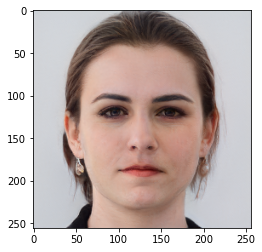

In [12]:
interpolated_images.shape
interpolated_images[5].shape

interpolated_images = (interpolated_images + 1) * (255/2)

interpolated_images = interpolated_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()

# plot the middle image
plt.imshow(interpolated_images[5])



<Figure size 432x288 with 0 Axes>

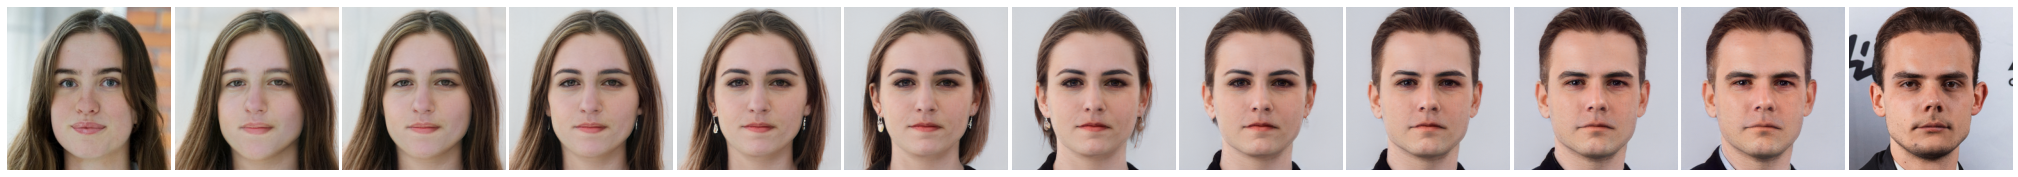

In [13]:
#clear the plot
plt.clf()

#insert face1array image in the begining and face2array image in the end
interpolated_images = np.insert(interpolated_images, 0, face1_array, axis=0)
interpolated_images = np.insert(interpolated_images, len(interpolated_images), face2_array, axis=0)

num_images = len(interpolated_images)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

if num_images == 1:
	axes = [axes]

for i, img in enumerate(interpolated_images):
	axes[i].imshow(img)
	axes[i].axis('off')
	axes[i].set_frame_on(False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

